In [1]:
import numpy as np
import seaborn as sns
sns.set(style='whitegrid')
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.csv')
data.shape
data = data[:100]
data.diagnosis = data.diagnosis.replace(to_replace=['B', 'M'], value=[0, 1])
data.sort_values(by=['diagnosis'])
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


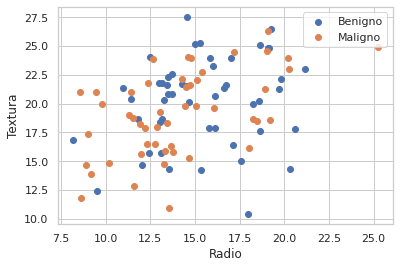

In [3]:
plt.scatter(data[:50].radius_mean, data[:50].texture_mean, label='Benigno')
plt.scatter(data[51:].radius_mean, data[51:].texture_mean, label='Maligno')
plt.xlabel('Radio')
plt.ylabel('Textura')
plt.legend(loc='best')


In [4]:
x = data.drop(labels=['id', 'diagnosis'], axis=1).values
y = data.diagnosis.values

In [5]:
# Partimos los datos - trainset: 80% y testset: 20%

# Semilla para numpy y tensorflow
import tensorflow as tf
seed = 5
np.random.seed(seed)
tf.set_random_seed(seed)

train_index = np.random.choice(len(x), round(len(x) * 0.8), replace=False)

# diff set
test_index = np.array(list(set(range(len(x))) - set(train_index)))
train_X = x[train_index]
train_y = y[train_index]
test_X = x[test_index]
test_y = y[test_index]

# Función de normalización
def min_max_normalized(data):
    col_max = np.max(data, axis=0)
    col_min = np.min(data, axis=0)
    return np.divide(data - col_min, col_max - col_min)

# Normalización
train_X = min_max_normalized(train_X)
test_X = min_max_normalized(test_X)

In [6]:
# Construcción del model framework

# Variables para aprender e inicializar
# Hay 30 características en el dataset, la dimesión de A es (30, 1)
import tensorflow as tf
A = tf.Variable(tf.random_normal(shape=[30, 1]))
b = tf.Variable(tf.random_normal(shape=[1, 1]))
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

# Placeholders
data = tf.placeholder(dtype=tf.float32, shape=[None, 30])
target = tf.placeholder(dtype=tf.float32, shape=[None, 1])

# Modelo a aprender
mod = tf.matmul(data, A) + b

# Función de pérdida usando la sigmoide.
# Primero se aplica la sigmoide en el resultado del modelo y luego usamos entropía cruzada
loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=mod, labels=target))

# Tasa de aprendizaje, tamaño del batch y número de iteraciones
learning_rate = 0.05
batch_size = 50
iter_num = 1500

# Optimizador
opt = tf.train.GradientDescentOptimizer(learning_rate)

# Objetivo
goal = opt.minimize(loss)

# Definir la precisión. Límite default 0.5 redondeado
prediction = tf.round(tf.sigmoid(mod))

# Bool a float32 
correct = tf.cast(tf.equal(prediction, target), dtype=tf.float32)

# Promedio
accuracy = tf.reduce_mean(correct)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [7]:
# Entrenamiento del modelo, variables para guardar los resultados
loss_trace = []
train_acc = []
test_acc = []

# Modelo de entrenamiento
for epoch in range(iter_num):
    # Random batch index
    batch_index = np.random.choice(len(train_X), size=batch_size)
    batch_train_X = train_X[batch_index]
    batch_train_y = np.matrix(train_y[batch_index]).T
    sess.run(goal, feed_dict={data: batch_train_X, target: batch_train_y})
    temp_loss = sess.run(loss, feed_dict={data: batch_train_X, target: batch_train_y})
    # Convertir a matriz para que coincida con la forma del placeholder de tf
    temp_train_acc = sess.run(accuracy, feed_dict={data: train_X, target: np.matrix(train_y).T})
    temp_test_acc = sess.run(accuracy, feed_dict={data: test_X, target: np.matrix(test_y).T})
    # Recode
    loss_trace.append(temp_loss)
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

    if (epoch + 1) % 300 == 0:
        print('epoch: {:4d} loss: {:5f} train_acc: {:5f} test_acc: {:5f}'.format(epoch + 1, temp_loss,
                                                                          temp_train_acc, temp_test_acc))

epoch:  300 loss: 0.455658 train_acc: 0.750000 test_acc: 0.850000
epoch:  600 loss: 0.370922 train_acc: 0.937500 test_acc: 0.900000
epoch:  900 loss: 0.239788 train_acc: 0.950000 test_acc: 0.900000
epoch: 1200 loss: 0.343737 train_acc: 0.950000 test_acc: 0.900000
epoch: 1500 loss: 0.271500 train_acc: 0.950000 test_acc: 0.900000


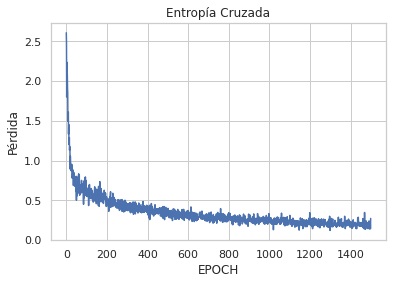

In [8]:
# Función de pérdida
plt.plot(loss_trace)
plt.title('Entropía Cruzada')
plt.xlabel('EPOCH')
plt.ylabel('Pérdida')
plt.show()

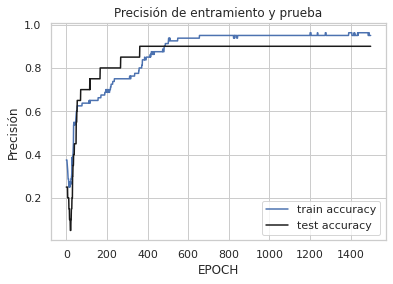

In [9]:
# Precisión
plt.plot(train_acc, 'b-', label='train accuracy')
plt.plot(test_acc, 'k-', label='test accuracy')
plt.xlabel('EPOCH')
plt.ylabel('Precisión')
plt.title('Precisión de entramiento y prueba')
plt.legend(loc='best')
plt.show()